# Exploration

This notebook is for exploring methods for statistical downscaling of SNAP's CMIP6 holdings.

It will both perform and evaluate the following methods:
1. Simple delta method
2. Quantile delta mapping of nearest-neighbor regridded GCM
3. Quantile delta mapping of bilinear-regridded GCM
4. Detrended quantile mapping

Each method will get its own section, which will include some preliminary evaluation. 

We will do this for three small domains in Alaska for this exploratory purpose, probably just for a single model? 


In [1]:
from pathlib import Path
import dask
import numpy as np

import xesmf as xe
import xarray as xr
import matplotlib.pyplot as plt
from xclim import sdba, set_options, units
import xclim.indicators as xci
from dask.distributed import LocalCluster, Client

from pyproj import CRS, Transformer, Proj

# downscaling project directory for writing inputs/outputs
downscaling_dir = Path("/beegfs/CMIP6/kmredilla/downscaling")

dask.config.set({"temporary-directory": "/beegfs/CMIP6/kmredilla/tmp"})

In [2]:
# The threads_per_worker=1 seems to have really helped with open_mfdataset()
# I think using a low number of workers is helping because very memory-intensive
#  operations are being done in parallel (like quantile operations with hundreds of qwuantiles)
cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 187.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40179,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 187.57 GiB
Comm: tcp://127.0.0.1:42999,Total threads: 1
Dashboard: http://127.0.0.1:34705/status,Memory: 46.89 GiB
Nanny: tcp://127.0.0.1:39859,


### ERA5 "fine" (target grid)

Here we will just open a connection to the ERA5 data which has been regridded to the target grid. See the [`regridding.ipynb`](./regridding.ipynb) notebook for derivation of this dataset. 

We will do a spatial subse to three domains over Alaska.

Load the ERA5 dataset on the target grid and 

In [ ]:
ref_ds = xr.open_mfdataset(downscaling_dir.joinpath("era5_fine.nc"))

We will do some spatial subsetting to speed up the development of the downscaling implementation and evaluation. 
We will define a dict of sample locations to center some windows for spatial subsetting on:

In [230]:
# functions to be pulled out into a separate module eventually


def get_ref_da(ref_ds, sel_di):
    """function for subsetting and prepping ref_da from ref_ds"""
    ref_da = ref_ds["t2max"].sel(sel_di).rename("tasmax")
    ref_da = ref_da.chunk({"x": 5, "y": 5})
    ref_da = ref_da.convert_calendar("noleap")
    ref_da.attrs["units"] = "K"
    ref_da = units.convert_units_to(ref_da, "degC")
    return ref_da


def get_sim_da(sim_ds, sel_di):
    """Don't need to do as much for sim_da as ref_da"""
    sim_da = (
        sim_ds["tasmax"]
        .sel(sel_di)
        .drop_vars(["lat", "lon"])
        .chunk({"time": -1, "x": 5, "y": 5})
    )

    return sim_da


# define a function to select a 10x10 window from the reference data centered on a given x, y point
def get_spatial_sel_di(x, y, res, window_size=10):
    """Create a selection dict for a window centered on a given x, y point."""
    half_window_dist = res * (window_size / 2)
    x_slice = slice(x - half_window_dist, x + half_window_dist)
    y_slice = slice(
        y + half_window_dist,
        y - half_window_dist,
    )

    return dict(x=x_slice, y=y_slice)


def plot_three_grids(
    da1, da2, da3, subtitle1, subtitle2, subtitle3, main_title, cbar_label
):
    """Plot a singe figure with two subplots side by side with shared colorbar."""
    fig, axes = plt.subplots(1, 3, figsize=(14, 6.5))

    vmin = min(da1.min(), da2.min(), da3.min())
    vmax = max(da1.max(), da2.max(), da3.max())
    im1 = da1.plot(
        ax=axes[0], vmin=vmin, vmax=vmax, add_colorbar=False, cmap="coolwarm"
    )
    axes[0].set_title(subtitle1)

    im2 = da2.plot(
        ax=axes[1], vmin=vmin, vmax=vmax, add_colorbar=False, cmap="coolwarm"
    )
    axes[1].set_title(subtitle2)

    im3 = da3.plot(
        ax=axes[2], vmin=vmin, vmax=vmax, add_colorbar=False, cmap="coolwarm"
    )
    axes[2].set_title(subtitle3)

    fig.suptitle(main_title)

    # Adjust layout to make space for the colorbar
    plt.tight_layout(rect=[0, 0.1, 1, 1])

    # Add a single colorbar for all subplots
    cbar = fig.colorbar(
        im1, ax=axes.ravel().tolist(), orientation="horizontal", fraction=0.08, pad=0.2
    )
    cbar.set_label(cbar_label)

    plt.show()


def plot_two_grids(da1, da2, main_title, subtitle1, subtitle2, cbar_label):
    """Plot a singe figure with two subplots side by side with shared colorbar."""
    fig, axes = plt.subplots(1, 2, figsize=(7, 3.5), sharey=True)

    vmin = min(da1.min(), da2.min())
    vmax = max(da1.max(), da2.max())
    im1 = da1.plot(
        ax=axes[0], vmin=vmin, vmax=vmax, add_colorbar=False, cmap="coolwarm"
    )
    axes[0].set_title(subtitle1)

    im2 = da2.plot(
        ax=axes[1], vmin=vmin, vmax=vmax, add_colorbar=False, cmap="coolwarm"
    )
    axes[1].set_title(subtitle2)
    axes[1].yaxis.set_visible(False)
    fig.suptitle(main_title)

    plt.tight_layout()

    # Adjust layout to make space for the colorbar
    plt.tight_layout(rect=[0, 0, 0.9, 1])

    # Add a single colorbar for all subplots
    cbar = fig.colorbar(
        im1, ax=axes.ravel().tolist(), orientation="vertical", fraction=0.02, pad=0.04
    )
    cbar.set_label(cbar_label)

    plt.show()


def train_qdm(ref_da, sim_da, window_n=31, quantiles_n=100, kind="+"):
    grouper = sdba.Grouper("time.dayofyear", window=int(window_n))

    qdm = sdba.adjustment.QuantileDeltaMapping.train(
        ref=ref_da,
        hist=sim_da,
        kind=kind,
        group=grouper,
        nquantiles=sdba.utils.equally_spaced_nodes(int(quantiles_n), eps=None),
    )

    return qdm


def subset_and_downscale(
    ref_ds, sim_ds, sel_di, window_n=31, quantiles_n=100, kind="+"
):

    ref_da = get_ref_da(ref_ds, sel_di)
    sim_da = get_sim_da(sim_ds, sel_di)

    qdm = train_qdm(
        ref_da, sim_da, window_n=window_n, quantiles_n=quantiles_n, kind=kind
    )
    sim_adj = qdm.adjust(sim_da)

    # return ref and sim dataarrays, and the trained qdm
    return {"sim_adj": sim_adj, "ref_da": ref_da, "sim_da": sim_da}

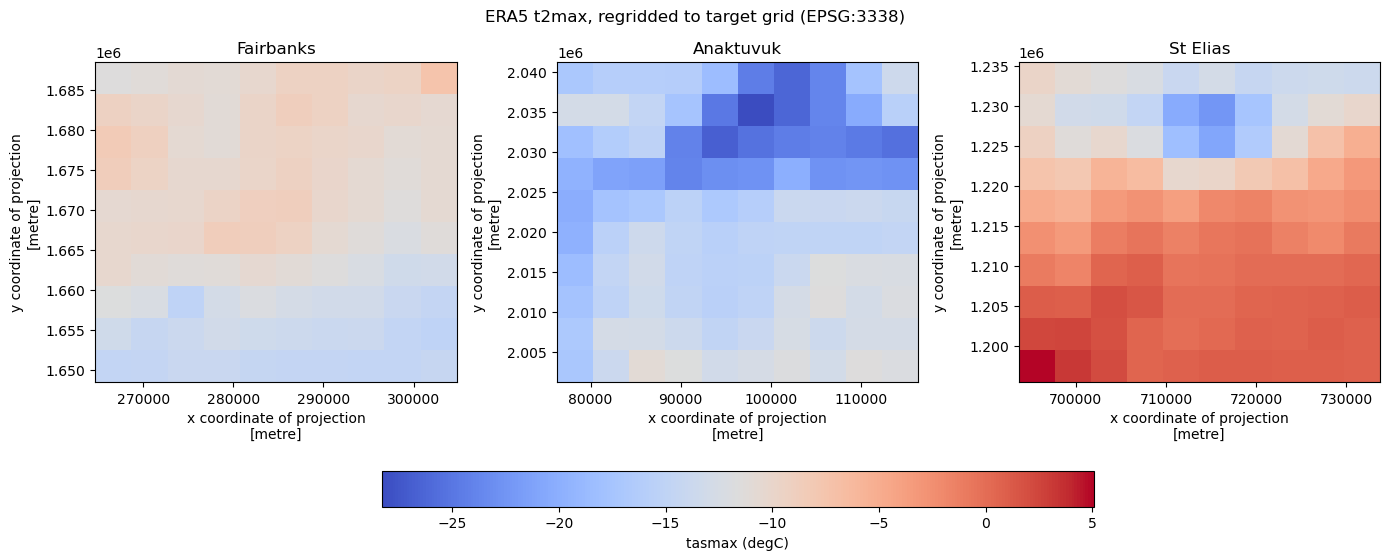

In [ ]:
# define a dict of points to center subsetting windows on
sample_points = {
    # shifting x and y for Fairbanks by -10000 and respectively to
    #  get a window that contains more of the original coarse grid data
    "Fairbanks": {"x": 286504, "y": 1667301},
    "Anaktuvuk": {"x": 95011, "y": 2021896},
    "St Elias": {"x": 715488, "y": 1215730},
}

sample_sel_dis = {}

plot_kwargs = {}
for i, (location, coords) in enumerate(sample_points.items()):
    sel_di = get_spatial_sel_di(x=coords["x"], y=coords["y"], res=4008)
    sample_sel_dis[location] = sel_di
    ref_da = get_ref_da(ref_ds, sel_di)
    ref_da = ref_da.isel(time=1).load()
    plot_kwargs[f"da{i + 1}"] = ref_da
    plot_kwargs[f"subtitle{i + 1}"] = location

plot_kwargs["main_title"] = "ERA5 t2max, regridded to target grid (EPSG:3338)"
plot_kwargs["cbar_label"] = "tasmax (degC)"

plot_three_grids(**plot_kwargs)

## Nearest-neighbor GCM target

Here we will apply QDM to GCM data that has been regridded to the target grid via nearest-neighbor resampling. 

Open connection to the NN-resampled "fine" historical GCM data:

In [ ]:
hist_fine_dir = downscaling_dir.joinpath("gfdl_historical_tasmax_fine")
hist_fine_fps = sorted(hist_fine_dir.glob("*.nc"))
sim_ds = xr.open_mfdataset(hist_fine_fps)

Let's now plot a sample slice for each location. Here you can see where each window is in relation to the regridded GCM data. This might be useful for reference later, where we can look to see whether these boundaries in the coarse grid are still present.

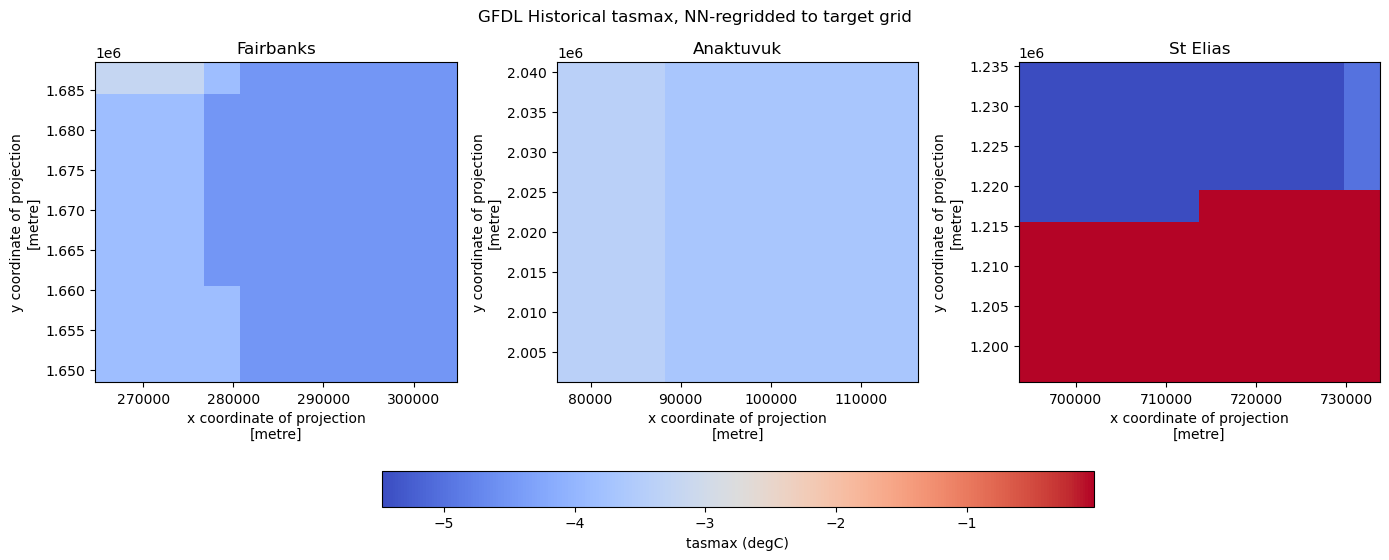

In [227]:
plot_kwargs = {}
for i, (location, coords) in enumerate(sample_points.items()):
    sim_da = get_sim_da(sim_ds, sample_sel_dis[location])
    sim_da = sim_da.isel(time=1).load()
    plot_kwargs[f"da{i + 1}"] = sim_da
    plot_kwargs[f"subtitle{i + 1}"] = location

plot_kwargs["main_title"] = "GFDL Historical tasmax, NN-regridded to target grid"
plot_kwargs["cbar_label"] = "tasmax (degC)"

plot_three_grids(**plot_kwargs)

Now run the QDM bias-adjustment for each location and store the results:

In [229]:
sample_sel_dis[location]

{'x': slice(266464.0, 306544.0, None), 'y': slice(1687341.0, 1647261.0, None)}

In [231]:
qdm_results = {}
for location in sample_sel_dis:
    qdm_results[location] = subset_and_downscale(
        ref_ds, sim_ds, sample_sel_dis[location]
    )

Plot some summaries:

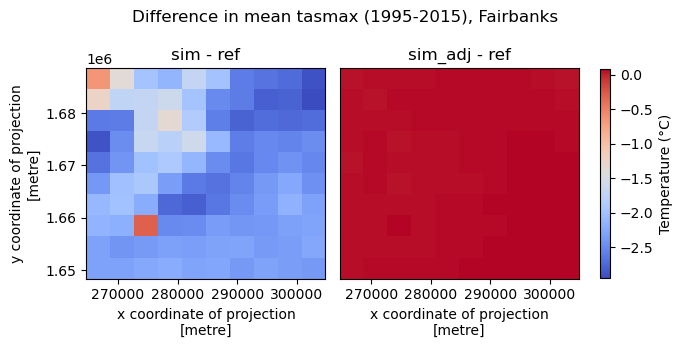

In [232]:
location = "Fairbanks"
delta_sim_ref = qdm_results[location]["sim_da"].mean(dim="time") - qdm_results[
    location
]["ref_da"].mean(dim="time")
delta_adj_ref = qdm_results[location]["sim_adj"].mean(dim="time") - qdm_results[
    location
]["ref_da"].mean(dim="time")

# need to load the data to plot, dask dataarrays are
#  buggin' out with this plotting for some reason
delta_sim_ref.load()
delta_adj_ref.load()

plot_two_grids(
    delta_sim_ref,
    delta_adj_ref,
    main_title=f"Difference in mean tasmax (1995-2015), {location}",
    subtitle1="sim - ref",
    subtitle2="sim_adj - ref",
    cbar_label="Temperature (°C)",
)

This makes sense. On the left, we can see the bias in the overall mean, and on the right we can see that bias has been removed.

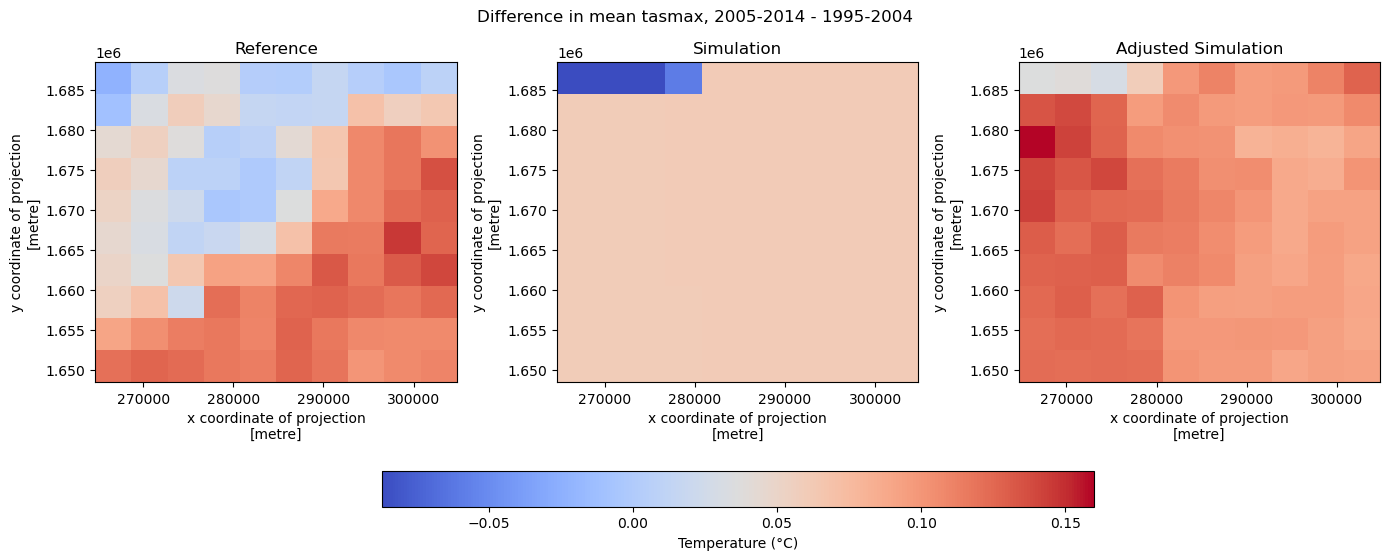

In [233]:
location = "Fairbanks"
ref = qdm_results[location]["ref_da"]
sim = qdm_results[location]["sim_da"]
adj = qdm_results[location]["sim_adj"]

tmp_ref = ref.isel(time=slice(3665, 7330)).mean(dim="time") - ref.isel(
    time=slice(0, 3665)
).mean(dim="time")
tmp_sim = sim.isel(time=slice(3650, 7300)).mean(dim="time") - sim.isel(
    time=slice(0, 3650)
).mean(dim="time")
tmp_adj = adj.isel(time=slice(3650, 7300)).mean(dim="time") - adj.isel(
    time=slice(0, 3650)
).mean(dim="time")

tmp_ref.load()
tmp_sim.load()
tmp_adj.load()

plot_three_grids(
    tmp_ref,
    tmp_sim,
    tmp_adj,
    main_title="Difference in mean tasmax, 2005-2014 - 1995-2004",
    subtitle1="Reference",
    subtitle2="Simulation",
    subtitle3="Adjusted Simulation",
    cbar_label="Temperature (°C)",
)

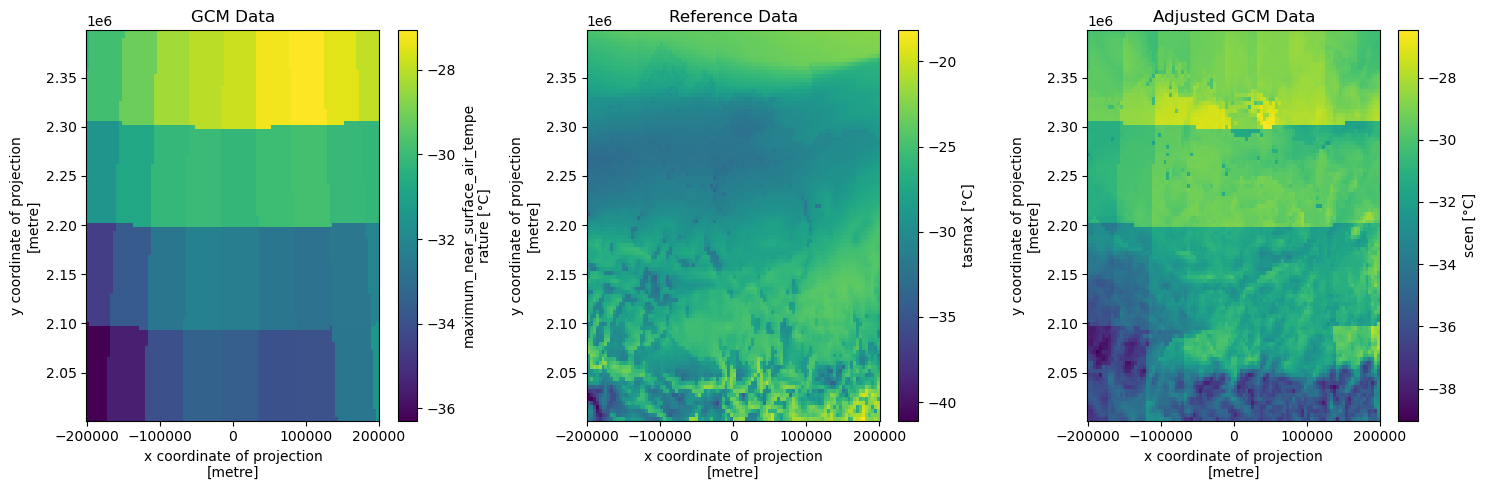

In [16]:
plt.figure(figsize=(15, 5))
date = "2000-01-01"

# Plot the first time slice of sim_da
plt.subplot(1, 3, 1)
sim_da.sel(time=date).plot()
plt.title("GCM Data")

# Plot the first time slice of ref_da
plt.subplot(1, 3, 2)
ref_da.sel(time=date).plot()
plt.title("Reference Data")

# Plot the first time slice of sim_adj.scen
plt.subplot(1, 3, 3)
sim_adj["scen"].sel(time=date).plot()
plt.title("Adjusted GCM Data")

plt.tight_layout()
plt.show()

### Bilinear GCM target

Open connection to the bilinear-interpolated "fine" historical GCM data:

In [17]:
hist_fine_dir = downscaling_dir.joinpath("gfdl_historical_tasmax_fine_bilinear")

hist_fine_fps = sorted(hist_fine_dir.glob("*.nc"))
sim_ds = xr.open_mfdataset(hist_fine_fps)

sim_da = sim_ds["tasmax"].sel(spatial_sel_di).chunk({"time": -1, "x": 20, "y": 20})
sim_da

<xarray.DataArray 'tasmax' (time: 7300, y: 99, x: 100)>
dask.array<rechunk-merge, shape=(7300, 99, 100), dtype=float32, chunksize=(7300, 20, 20), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1995-01-01 12:00:00 ... 2014-12-31 12:00:00
  * x        (x) float64 -1.983e+05 -1.943e+05 ... 1.945e+05 1.986e+05
  * y        (y) float64 2.396e+06 2.392e+06 2.388e+06 ... 2.007e+06 2.003e+06
    lon      (y, x) float64 dask.array<chunksize=(20, 20), meta=np.ndarray>
    lat      (y, x) float64 dask.array<chunksize=(20, 20), meta=np.ndarray>
Attributes:
    long_name:             maximum_near_surface_air_temperature
    parent_interp_method:  conserve_order2
    original_name:         tasmax
    standard_name:         air_temperature
    cell_measures:         area: areacella
    regrid_method:         bilinear
    cell_methods:          area: mean time: maximum
    interp_method:         bilinear
    units:                 °C
    grid_mapping:          spatial_ref

In [22]:
qdm = sdba.adjustment.QuantileDeltaMapping.train(
    ref=ref_da,
    hist=sim_da,
    kind=kind,
    group=grouper,
    nquantiles=equally_spaced_nodes(int(quantiles_n), eps=None),
)

year = 2000

with set_options(sdba_extra_output=True):
    sim_adj = qdm.adjust(sim_da.sel(time=str(year)))

sim_adj.load()

<xarray.Dataset>
Dimensions:  (y: 99, x: 100, time: 365)
Coordinates:
  * y        (y) float64 2.396e+06 2.392e+06 2.388e+06 ... 2.007e+06 2.003e+06
  * x        (x) float64 -1.983e+05 -1.943e+05 ... 1.945e+05 1.986e+05
  * time     (time) object 2000-01-01 12:00:00 ... 2000-12-31 12:00:00
    lat      (y, x) float64 71.49 71.5 71.5 71.5 ... 67.93 67.93 67.93 67.93
    lon      (y, x) float64 -159.5 -159.3 -159.2 -159.1 ... -149.5 -149.4 -149.3
Data variables:
    scen     (y, x, time) float32 nan nan nan nan ... -30.51 -29.44 -28.02 -13.5
    sim_q    (y, x, time) float64 nan nan nan nan nan ... 1.0 1.0 1.0 1.0 1.0

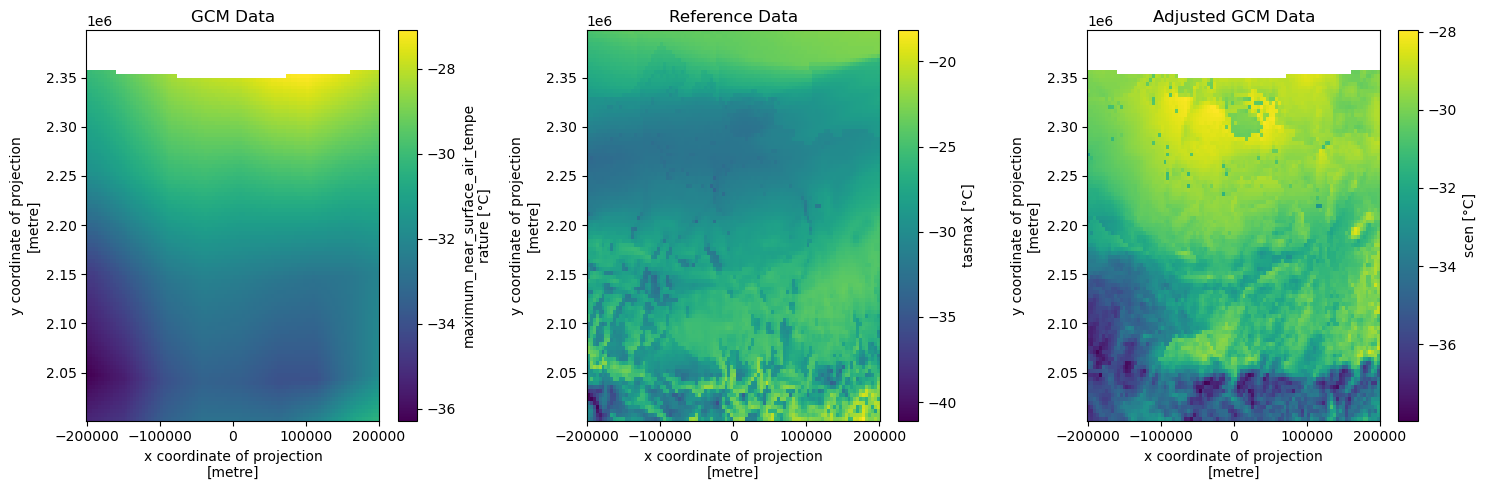

In [21]:
plt.figure(figsize=(15, 5))
date = "2000-01-01"

# Plot the first time slice of sim_da
plt.subplot(1, 3, 1)
sim_da.sel(time=date).plot()
plt.title("GCM Data")

# Plot the first time slice of ref_da
plt.subplot(1, 3, 2)
ref_da.sel(time=date).plot()
plt.title("Reference Data")

# Plot the first time slice of sim_adj.scen
plt.subplot(1, 3, 3)
sim_adj["scen"].sel(time=date).plot()
plt.title("Adjusted GCM Data")

plt.tight_layout()
plt.show()

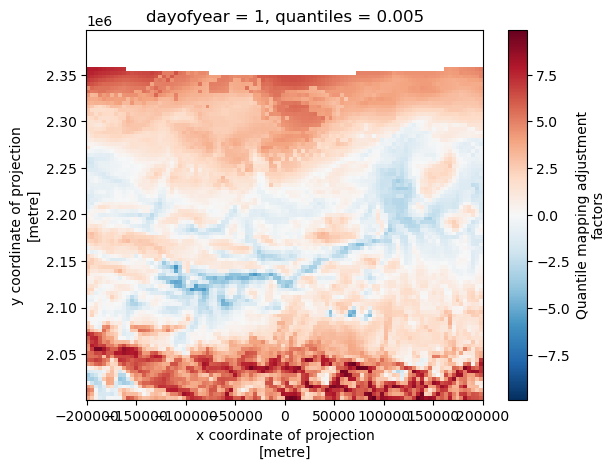

In [29]:
qdm.ds.af.isel(dayofyear=0, quantiles=0).plot()